<a href="https://colab.research.google.com/github/mafudsetiono/Churn-Analysis/blob/main/Churn_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Identifikasi Masalah
Perusahaan ingin tahu pelanggan mana yang berpotensi churn (berhenti) supaya bisa dicegah lebih awal.

oleh karena itu saya membuat sistem yang bisa peringatkan perusahaan lebih awal pelanggan mana yang kemungkinan besar akan pergi beserta action plan yang dapat dilakukan.

Link Github : https://github.com/mafudsetiono

Linkedin    : https://www.linkedin.com/in/mafud-satrio-setiono-5950a7266/

# Impact yang ingin dicapai

## Impact Bisnis
- Mengurangi Customer churn
- Meningkatkan Customer retention
- Lebih efisien dalam:
   - Promo
   - Diskon
   - Loyalty Program
- Fokus ke pelanggan yang benar-benar beresiko churn, bukan semua.

Daripada kasih promo ke semua pelanggan, perusahaan bisa target hanya 10-20% pelanggan berisiko tinggi churn.

## Impact Data Scientist
- Mengubah Data Historis menjadi decision support
- Metric Eval:
  - Recall (Penting)
  - Accuracy
  - Precision
  - F1-score
  - Confusion Matrix
  
  Lebih baik salah alarm daripada kehilangan pelanggan churn.
- Model bisa :     
  - Prediksi churn Yes/No
  - Menunjukkan probabilitas churn
- Menjawab pertanyaan:
  - Faktor apa yang paling berpengaruh
  - Apakah durasi telpon, CS Call, atau plan tertentu


#Data Understanding

In [101]:
#Import Library
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay, roc_auc_score, roc_curve, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold

In [12]:
df = pd.read_csv("/content/churn-bigml-20.csv")
df.head()

,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
0,LA,117,408,No,No,0,184.5,97,31.37,351.6,80,29.89,215.8,90,9.71,8.7,4,2.35,1,False
1,IN,65,415,No,No,0,129.1,137,21.95,228.5,83,19.42,208.8,111,9.40,12.7,6,3.43,4,True
2,NY,161,415,No,No,0,332.9,67,56.59,317.8,97,27.01,160.6,128,7.23,5.4,9,1.46,4,True
3,SC,111,415,No,No,0,110.4,103,18.77,137.3,102,11.67,189.6,105,8.53,7.7,6,2.08,2,False
4,HI,49,510,No,No,0,119.3,117,20.28,215.1,109,18.28,178.7,90,8.04,11.1,1,3.00,1,False


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 667 entries, 0 to 666
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   State                   667 non-null    object 
 1   Account length          667 non-null    int64  
 2   Area code               667 non-null    int64  
 3   International plan      667 non-null    object 
 4   Voice mail plan         667 non-null    object 
 5   Number vmail messages   667 non-null    int64  
 6   Total day minutes       667 non-null    float64
 7   Total day calls         667 non-null    int64  
 8   Total day charge        667 non-null    float64
 9   Total eve minutes       667 non-null    float64
 10  Total eve calls         667 non-null    int64  
 11  Total eve charge        667 non-null    float64
 12  Total night minutes     667 non-null    float64
 13  Total night calls       667 non-null    int64  
 14  Total night charge      667 non-null    fl

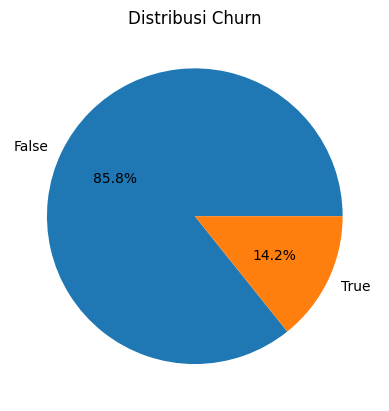

In [14]:
plt.pie(df["Churn"].value_counts(), labels=df["Churn"].value_counts().index, autopct="%1.1f%%")
plt.title("Distribusi Churn")
plt.show()

## Insight
Data terdiri dari 20 kolom dan 667 baris tanpa missing value.

Distribusi churn menunjukkan bahwa mayoritas pelanggan tidak churn, sehingga dataset cenderung imbalanced. Hal ini perlu diperhatikan dalam pemilihan metrik evaluasi model.

#Data Cleaning

In [15]:
# Cek duplikasi
df.duplicated().sum()

np.int64(0)

Data sudah bersih tanpa missing value dan tanpa duplikat.

In [16]:
# cek outlier
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns
numerical_cols

Index(['Account length', 'Area code', 'Number vmail messages',
       'Total day minutes', 'Total day calls', 'Total day charge',
       'Total eve minutes', 'Total eve calls', 'Total eve charge',
       'Total night minutes', 'Total night calls', 'Total night charge',
       'Total intl minutes', 'Total intl calls', 'Total intl charge',
       'Customer service calls'],
      dtype='object')

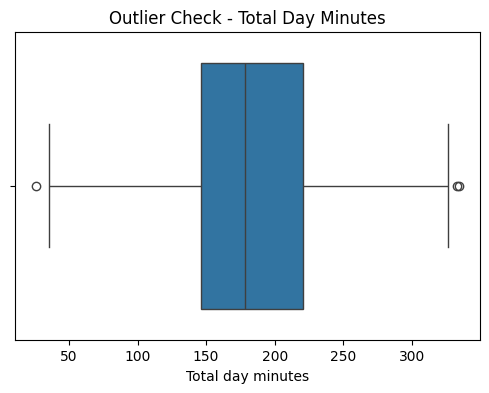

In [17]:
plt.figure(figsize=(6,4))
sns.boxplot(x=df['Total day minutes'])
plt.title("Outlier Check - Total Day Minutes")
plt.show()

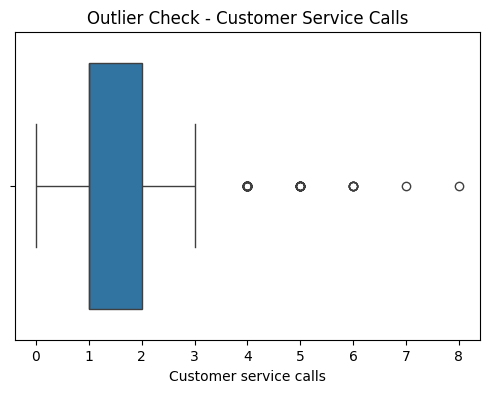

In [18]:
plt.figure(figsize=(6,4))
sns.boxplot(x=df['Customer service calls'])
plt.title("Outlier Check - Customer Service Calls")
plt.show()

Outlier tetap dipertahankan karena dapat merepresentasikan perilaku pelanggan dengan penggunaan ekstrem yang relevan secara bisnis.

#EDA
Filtering fitur yang Relevan

Perilaku & pengalaman pelanggan:
- Customer service calls
- Total day minutes

Paket / Plan (Jenis Layanan)
- Interntational Plan

  Pelanggan berlangganan layanan telpon internasional atau tidak

- Voice mail plan

  Apakah pelanggan mengaktifkan layanan voicemail

Pemilihan variabel plan didasarkan pada relevansi bisnis dan representasi perilaku pelanggan. International plan berkaitan langsung dengan struktur biaya dan potensi ketidakpuasan pelanggan, sedangkan voice mail plan merepresentasikan tingkat engagement pelanggan terhadap layanan. Kedua variabel ini dipilih karena secara logis berpotensi memengaruhi churn.

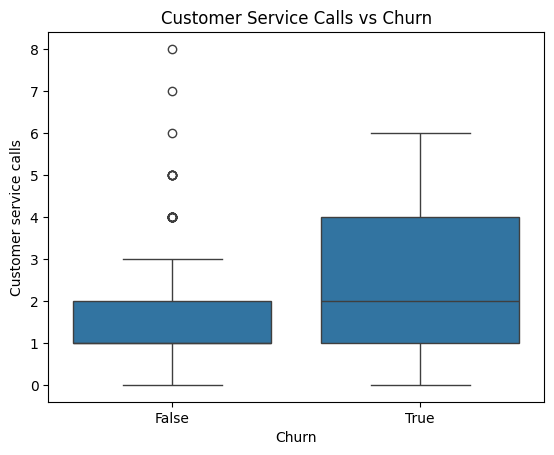

In [19]:
sns.boxplot(x='Churn', y='Customer service calls', data=df)
plt.title("Customer Service Calls vs Churn")
plt.show()

In [20]:
df.groupby('Churn')['Customer service calls'].mean()

,Customer service calls
Churn,
False,1.437063
True,2.326316


Pelanggan yang churn cenderung memiliki jumlah panggilan ke customer service yang lebih tinggi, yang mengindikasikan adanya masalah atau ketidakpuasan terhadap layanan.

##Total Day Minutes vs Churn

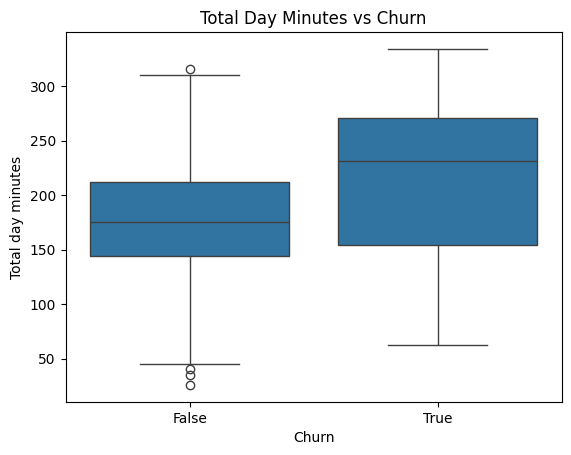

In [21]:
sns.boxplot(x='Churn', y='Total day minutes', data=df)
plt.title("Total Day Minutes vs Churn")
plt.show()

##Total Day Charges vs Churn

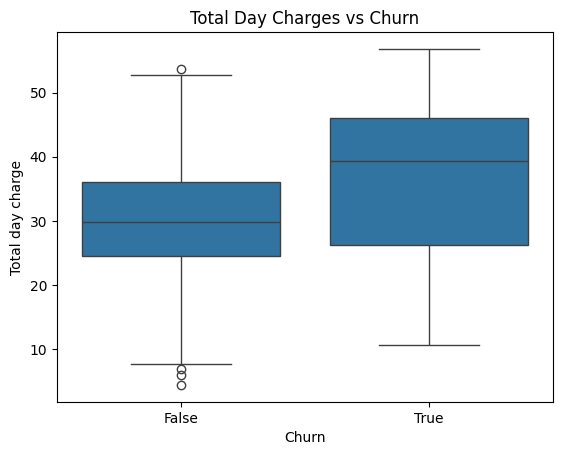

In [22]:
sns.boxplot(x='Churn', y='Total day charge', data=df)
plt.title("Total Day Charges vs Churn")
plt.show()

Pelanggan yang churn cenderung memiliki total penggunaan layanan di siang hari yang lebih tinggi dibandingkan pelanggan yang tidak churn. Hal ini mengindikasikan bahwa tingkat penggunaan yang tinggi, yang berpotensi berkaitan dengan biaya, dapat menjadi salah satu faktor yang berasosiasi dengan churn.

##International Plan vs Churn

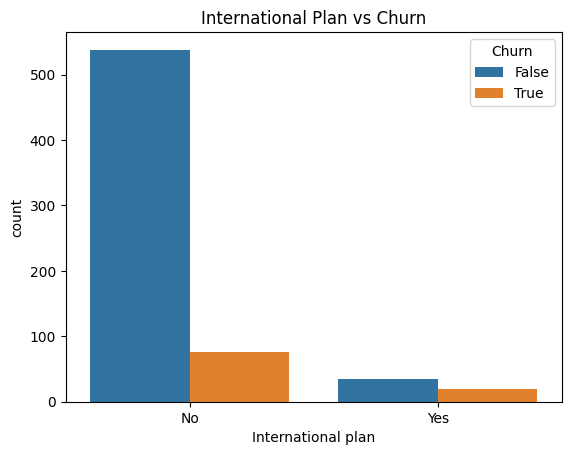

In [23]:
sns.countplot(x='International plan', hue='Churn', data=df)
plt.title("International Plan vs Churn")
plt.show()

In [24]:
pd.crosstab(df['International plan'], df['Churn'], normalize='index') * 100

Churn,False,True
International plan,,
No,87.622150,12.377850
Yes,64.150943,35.849057


Penggunaan international plan berkorelasi dengan tingkat churn yang lebih tinggi. Hal ini mengindikasikan bahwa pelanggan dengan international plan cenderung lebih sensitif terhadap aspek biaya, kualitas layanan, atau alternatif layanan lain, sehingga memiliki kecenderungan churn yang lebih besar.

##Voice Mail Plan vs Churn

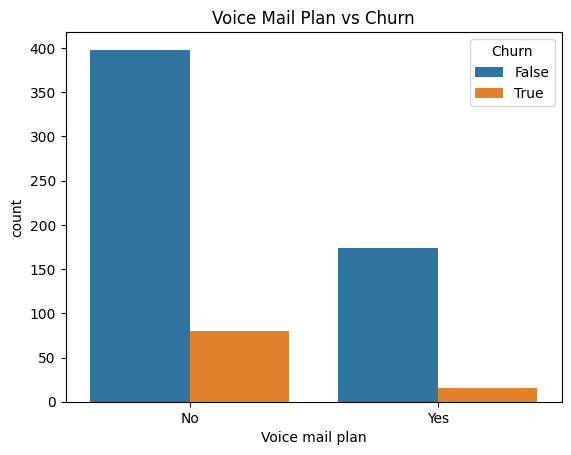

In [25]:
sns.countplot(x='Voice mail plan', hue='Churn', data=df)
plt.title("Voice Mail Plan vs Churn")
plt.show()

In [26]:
pd.crosstab(df['Voice mail plan'], df['Churn'], normalize='index') * 100

Churn,False,True
Voice mail plan,,
No,83.263598,16.736402
Yes,92.063492,7.936508


Pelanggan yang memiliki voice mail plan cenderung memiliki tingkat churn yang lebih rendah dibandingkan pelanggan yang tidak memiliki voice mail plan.

##Correlation Heatmap

In [27]:
df_corr = df.copy()
df_corr = df_corr.drop(['State', 'Area code'], axis=1)
df_corr['International plan'] = df_corr['International plan'].map({'Yes': 1, 'No': 0})
df_corr['Voice mail plan'] = df_corr['Voice mail plan'].map({'Yes': 1, 'No': 0})
df_corr['Churn'] = df_corr['Churn'].map({True: 1, False: 0})

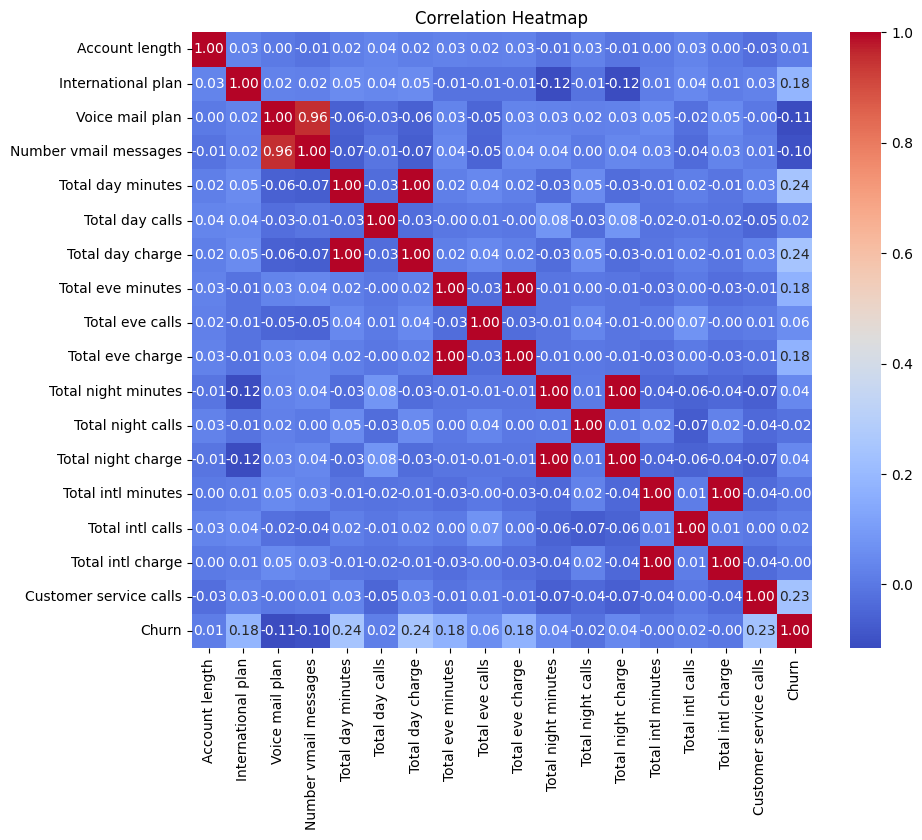

In [28]:
corr = df_corr.corr()
corr['Churn'].sort_values(ascending=False)
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

Hasil analisis korelasi menunjukkan bahwa variabel yang berkaitan dengan penggunaan layanan dan pengalaman pelanggan, seperti total day minutes, total day charge, dan customer service calls, memiliki korelasi positif terhadap churn. Sementara itu, voice mail plan menunjukkan korelasi negatif terhadap churn, yang mengindikasikan keterikatan pelanggan. Secara umum nilai korelasi relatif rendah, menandakan bahwa churn dipengaruhi oleh kombinasi berbagai faktor dan tidak bergantung pada satu variabel tunggal.

## Insight EDA
Pelanggan churn cenderung merupakan pengguna aktif dengan biaya layanan yang relatif tinggi, yang berpotensi merasa nilai layanan tidak sebanding dengan biaya yang dikeluarkan.

# Feature Selection

In [29]:
features = [
    'International plan',
    'Voice mail plan',
    'Customer service calls',
    'Total day charge',
    'Total eve charge'
]

X = df[features]
y = df['Churn']

Pemilihan fitur dilakukan berdasarkan kombinasi relevansi bisnis, hasil exploratory data analysis, serta analisis korelasi. Fitur yang bersifat redundant dihilangkan untuk mengurangi multikolinearitas dan meningkatkan interpretabilitas model. Fitur final mencerminkan aspek pengalaman pelanggan, jenis layanan, serta biaya penggunaan yang relevan terhadap churn.

## Encode Fitur Kategorikal

In [30]:
y = y.map({True: 1, False: 0})

In [31]:
X['International plan'] = X['International plan'].map({'Yes': 1, 'No': 0})
X['Voice mail plan'] = X['Voice mail plan'].map({'Yes': 1, 'No': 0})

/tmp/ipython-input-3278595805.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['International plan'] = X['International plan'].map({'Yes': 1, 'No': 0})
/tmp/ipython-input-3278595805.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Voice mail plan'] = X['Voice mail plan'].map({'Yes': 1, 'No': 0})


Penggunaan binary encoding digunakan karena hanya 2 kategorikal, jadi tidak perlu OHE


# Train-Test Split

In [32]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

#Scaling

In [33]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Fit hanya dilakukan kepada data train agar tidak bocor informasi dari test set (Data Leakage)

In [34]:
y_train.value_counts(normalize=True)
y_test.value_counts(normalize=True)

,proportion
Churn,
0,0.858209
1,0.141791


#Baseline Model

Dalam proses pemodelan, digunakan algoritma supervised learning yang sesuai dengan tujuan prediksi churn pelanggan, yaitu Logistic Regression dengan regularisasi Ridge dan Lasso, serta Random Forest.

#Logistic Regression (Ridge & Lasso)

In [35]:
log_reg_baseline = LogisticRegression(
    max_iter=1000,
    class_weight='balanced',
    random_state=42
)

log_reg_baseline.fit(X_train_scaled, y_train)


LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

In [36]:
y_pred = log_reg_baseline.predict(X_test_scaled)
y_proba = log_reg_baseline.predict_proba(X_test_scaled)[:,1]

## Metric eval

In [37]:
# Evaluasi Model Baseline
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.84      0.89       115
           1       0.42      0.68      0.52        19

    accuracy                           0.82       134
   macro avg       0.68      0.76      0.70       134
weighted avg       0.87      0.82      0.84       134



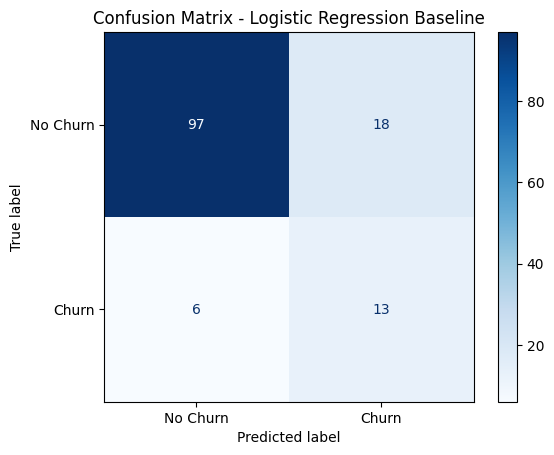

In [38]:
disp = ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred,
    display_labels=['No Churn', 'Churn'],
    cmap='Blues',
    values_format='d'
)

plt.title('Confusion Matrix - Logistic Regression Baseline')
plt.show()

Model mampu mengidentifikasi sekitar 68% pelanggan yang berpotensi churn, meskipun menghasilkan sejumlah false positive. Dalam konteks retensi pelanggan, pendekatan ini dapat diterima karena lebih baik melakukan intervensi berlebih dibandingkan kehilangan pelanggan yang benar-benar akan churn.

In [39]:
roc_auc_score(y_test, y_proba)

np.float64(0.8100686498855836)

In [40]:
baseline_recall = classification_report(
    y_test,
    y_pred,
    output_dict=True
)['1']['recall']

baseline_auc = roc_auc_score(y_test, y_proba)

baseline_recall, baseline_auc


(0.6842105263157895, np.float64(0.8100686498855836))

#Hyperparameter Tuning





In [41]:
cv = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=42
)

In [42]:
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100]
}

Stratified cross-validation digunakan untuk menjaga proporsi kelas churn dan non-churn tetap seimbang pada setiap fold.

## Ridge

In [43]:
log_reg_ridge = LogisticRegression(
    penalty='l2',
    solver='liblinear',
    class_weight='balanced',
    max_iter=1000,
    random_state=42
)

In [44]:
# GridSearch
grid_ridge = GridSearchCV(
    estimator=log_reg_ridge,
    param_grid=param_grid,
    scoring='recall',
    cv=cv,
    n_jobs=-1
)

grid_ridge.fit(X_train_scaled, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=LogisticRegression(class_weight='balanced',
                                          max_iter=1000, random_state=42,
                                          solver='liblinear'),
             n_jobs=-1, param_grid={'C': [0.01, 0.1, 1, 10, 100]},
             scoring='recall')

In [45]:
grid_ridge.best_params_, grid_ridge.best_score_

({'C': 0.01}, np.float64(0.7608333333333334))

In [46]:
best_ridge = grid_ridge.best_estimator_

y_pred_ridge = best_ridge.predict(X_test_scaled)
y_proba_ridge = best_ridge.predict_proba(X_test_scaled)[:,1]

In [47]:
# Evaluasi Model Ridge tuned
print(classification_report(y_test, y_pred_ridge))

              precision    recall  f1-score   support

           0       0.96      0.78      0.86       115
           1       0.38      0.79      0.51        19

    accuracy                           0.78       134
   macro avg       0.67      0.79      0.68       134
weighted avg       0.87      0.78      0.81       134



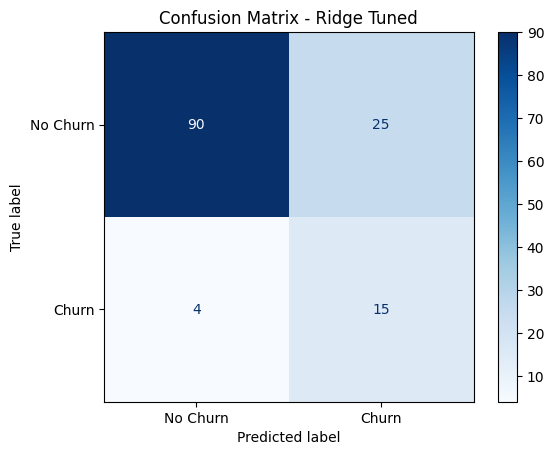

In [59]:
disp = ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred_ridge,
    display_labels=['No Churn', 'Churn'],
    cmap='Blues',
    values_format='d'
)

plt.title('Confusion Matrix - Ridge Tuned')
plt.show()

Model Ridge (C=0.01) meningkatkan recall churn dari 0.68 menjadi 0.79. Model menjadi lebih efektif dalam mendeteksi pelanggan berisiko churn, meskipun terjadi penurunan precision sebagai konsekuensi trade-off.

##Lasso

In [49]:
log_reg_lasso = LogisticRegression(
    penalty='l1',
    solver='liblinear',
    class_weight='balanced',
    max_iter=1000,
    random_state=42
)

In [50]:
# GridSearch
grid_lasso = GridSearchCV(
    estimator=log_reg_lasso,
    param_grid=param_grid,
    scoring='recall',
    cv=cv,
    n_jobs=-1
)

grid_lasso.fit(X_train_scaled, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=LogisticRegression(class_weight='balanced',
                                          max_iter=1000, penalty='l1',
                                          random_state=42, solver='liblinear'),
             n_jobs=-1, param_grid={'C': [0.01, 0.1, 1, 10, 100]},
             scoring='recall')

In [51]:
grid_lasso.best_params_, grid_lasso.best_score_

({'C': 0.1}, np.float64(0.7350000000000001))

In [52]:
best_lasso = grid_lasso.best_estimator_

y_pred_lasso = best_lasso.predict(X_test_scaled)
y_proba_lasso = best_lasso.predict_proba(X_test_scaled)[:,1]

In [53]:
# Evaluasi Model Lasso tuned
print(classification_report(y_test, y_pred_lasso))

              precision    recall  f1-score   support

           0       0.94      0.83      0.88       115
           1       0.39      0.68      0.50        19

    accuracy                           0.81       134
   macro avg       0.67      0.76      0.69       134
weighted avg       0.86      0.81      0.83       134



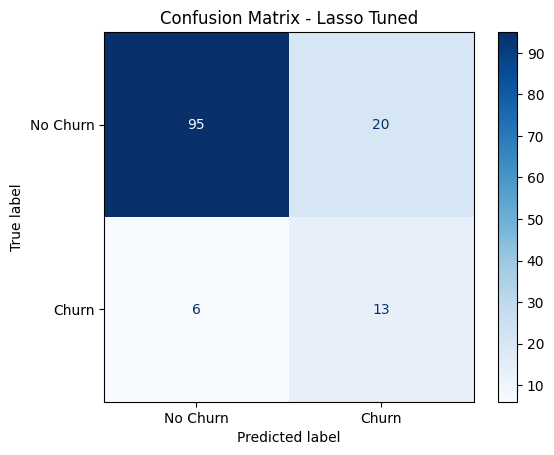

In [54]:
disp = ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred_lasso,
    display_labels=['No Churn', 'Churn'],
    cmap='Blues',
    values_format='d'
)

plt.title('Confusion Matrix - Lasso Tuned')
plt.show()

Performa Lasso yang tidak meningkat menunjukkan bahwa dataset ini tidak mengalami overfitting akibat banyaknya fitur, serta tidak memiliki fitur yang terlalu lemah sehingga perlu dieliminasi secara agresif.

#Random Forest

In [55]:
rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    class_weight='balanced',
    random_state=42
)

rf.fit(X_train_scaled, y_train)

RandomForestClassifier(class_weight='balanced', n_estimators=200,
                       random_state=42)

In [56]:
y_pred_rf = rf.predict(X_test_scaled)
y_proba_rf = rf.predict_proba(X_test_scaled)[:,1]

print(confusion_matrix(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))

rf_auc = roc_auc_score(y_test, y_proba_rf)
rf_auc

[[113   2]
 [  8  11]]
              precision    recall  f1-score   support

           0       0.93      0.98      0.96       115
           1       0.85      0.58      0.69        19

    accuracy                           0.93       134
   macro avg       0.89      0.78      0.82       134
weighted avg       0.92      0.93      0.92       134



np.float64(0.9084668192219678)

In [57]:
y_pred_rf_custom = (y_proba_rf >= 0.4).astype(int)

print(confusion_matrix(y_test, y_pred_rf_custom))
print(classification_report(y_test, y_pred_rf_custom))

[[111   4]
 [  7  12]]
              precision    recall  f1-score   support

           0       0.94      0.97      0.95       115
           1       0.75      0.63      0.69        19

    accuracy                           0.92       134
   macro avg       0.85      0.80      0.82       134
weighted avg       0.91      0.92      0.91       134



Beberapa model dibandingkan untuk menentukan pendekatan terbaik dalam memprediksi churn, yaitu Logistic Regression (baseline), Ridge Logistic Regression, dan Random Forest.

Model Random Forest menunjukkan nilai ROC-AUC tertinggi (0.91), yang mengindikasikan kemampuan separasi probabilistik yang sangat baik. Namun, pada threshold yang disesuaikan (0.4), recall churn hanya mencapai 0.63.

Sementara itu, model Ridge Logistic Regression menghasilkan recall tertinggi sebesar 0.79, yang berarti model mampu mendeteksi sekitar 79% pelanggan yang benar-benar churn.

Dalam konteks bisnis, kesalahan mendeteksi pelanggan churn (false negative) memiliki dampak yang lebih besar dibandingkan false positive. Oleh karena itu, model Ridge Logistic Regression dipilih sebagai model akhir karena memiliki kemampuan deteksi churn yang lebih tinggi, meskipun dengan trade-off pada precision.

#Simulasi Impact

Asumsikan 1 pelanggan churn --> rugi 500K

Biaya Intervensi(Retensi/Campaign) = 50K

In [89]:
# Tanpa Model
churn = 19 # TP
kerugian_tiap_churn = 500000
tanpa_model = churn * kerugian_tiap_churn
print(tanpa_model)

9500000


Tanpa Model, perusahaan bisa rugi sampai 9,5 juta

In [92]:
# With Model
model_churn = 15 # TP

# Semisal campaign nya berhasil mempertahankan/menyelamatkan pelanggan 80% dari yang terdeteksi churn
pelanggan_diselamatkan = 15 * 80/100
print('Pelanggan yang terselamatkan:', pelanggan_diselamatkan)

# Pelanggan yang lolos walau sudah diberi campaign
churn_lolos = model_churn - pelanggan_diselamatkan
print('Pelanggan yang akan churn:', churn_lolos)

# 20% Gagal Pertahankan
gagal_pertahankan = churn_lolos * kerugian_tiap_churn
print('Gagal pertahankan dari Campaign: Rp', gagal_pertahankan)


Pelanggan yang terselamatkan: 12.0
Pelanggan yang akan churn: 3.0
Gagal pertahankan dari Campaign: Rp 1500000.0


In [84]:
#Biaya Campaign
cost = 50000
model_prediksi_churn = 40
biaya_campaign = model_prediksi_churn * cost
print(biaya_campaign)

2000000


In [93]:
# Total Biaya dengan model
total_cost = gagal_pertahankan + biaya_campaign
print(total_cost)

3500000.0


In [94]:
# Perbandingan with model dan tanpa model
print('Dengan Model:', total_cost)
print('Tanpa Model:', tanpa_model)
print('Opprtunity Cost:', tanpa_model - total_cost)

Dengan Model: 3500000.0
Tanpa Model: 9500000
Opprtunity Cost: 6000000.0


## Simulasi Dampak Bisnis Model Churn

Berdasarkan simulasi, tanpa model prediksi perusahaan berpotensi mengalami kerugian sebesar Rp 9.500.000 akibat 19 pelanggan yang churn.

Dengan menggunakan model Ridge Logistic Regression, sebanyak 15 pelanggan churn berhasil terdeteksi. Dengan asumsi tingkat keberhasilan campaign retensi sebesar 80%, perusahaan dapat mempertahankan 12 pelanggan.

Setelah memperhitungkan biaya campaign sebesar Rp 2.000.000 serta kerugian dari 3 pelanggan yang tetap churn, total biaya menjadi Rp 3.500.000.

Dengan demikian, model prediksi churn berpotensi mengurangi kerugian sebesar Rp 6.000.000 atau sekitar 63% dibandingkan tanpa model.

Hasil ini menunjukkan bahwa implementasi model prediksi churn memberikan dampak finansial yang signifikan bagi perusahaan.

#Business Recommendation

Berdasarkan hasil analisis dan modeling, faktor yang paling berpengaruh terhadap churn adalah jumlah panggilan ke customer service, diikuti oleh tingkat penggunaan dan biaya layanan siang hari, serta kepemilikan international plan.

Pelanggan yang sering menghubungi customer service menunjukkan risiko churn yang lebih tinggi, yang mengindikasikan adanya ketidakpuasan terhadap layanan. Oleh karena itu, perusahaan perlu melakukan monitoring khusus terhadap pelanggan dengan frekuensi customer service calls yang tinggi.

Selain itu, pelanggan dengan penggunaan dan biaya layanan yang tinggi cenderung memiliki risiko churn lebih besar, kemungkinan karena persepsi bahwa biaya tidak sebanding dengan nilai layanan. Perusahaan dapat mempertimbangkan program loyalitas atau paket khusus untuk segmen ini.

Pelanggan dengan international plan juga menunjukkan tingkat churn yang lebih tinggi, sehingga perlu strategi pricing atau peningkatan kualitas layanan internasional.

Sebaliknya, pelanggan yang menggunakan voice mail plan menunjukkan tingkat churn yang lebih rendah, yang mengindikasikan bahwa adopsi fitur tambahan dapat meningkatkan keterikatan pelanggan.

Secara keseluruhan, strategi retensi yang proaktif terhadap pelanggan berisiko tinggi dapat memberikan dampak finansial yang signifikan, sebagaimana ditunjukkan dalam simulasi penghematan sebesar 63%.

#Preparation Before Streamlit


Karena Kebutuhan Identifier, saya membuat kolom customer_id

In [100]:
df.duplicated().sum()

np.int64(0)

In [95]:
df.insert(0, "customer_id", range(1, len(df) + 1))

In [98]:
df.sample(5)

,customer_id,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,...,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
551,552,NM,178,415,No,Yes,35,175.4,88,29.82,...,65,16.15,138.7,94,6.24,10.5,3,2.84,2,False
370,371,AL,68,510,No,No,0,157.3,83,26.74,...,85,18.78,218.9,129,9.85,12.0,7,3.24,1,False
519,520,AL,76,415,No,No,0,179.2,85,30.46,...,66,18.95,188.2,113,8.47,12.4,2,3.35,0,False
591,592,MO,101,415,Yes,No,0,156.4,116,26.59,...,114,11.08,207.3,109,9.33,7.3,5,1.97,1,False
303,304,NM,55,510,No,No,0,119.7,148,20.35,...,96,19.70,222.3,113,10.00,4.6,2,1.24,2,False


In [102]:
#Save Model
joblib.dump(best_ridge, "churn_model.pkl")
joblib.dump(scaler, "scaler.pkl")

['scaler.pkl']

Karena model Ridge dilatih menggunakan data yang telah melalui proses standardisasi, maka objek StandardScaler perlu disimpan dan digunakan kembali pada tahap prediksi di aplikasi Streamlit.

Hal ini bertujuan untuk memastikan bahwa data input baru mengalami transformasi yang identik dengan data training, sehingga distribusi fitur tetap konsisten dan hasil prediksi tetap valid.

Tanpa penggunaan scaler yang sama, model dapat menghasilkan prediksi yang tidak akurat akibat perbedaan skala fitur.